In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
def load_astro_ph_graph(file_path, limit=None):
    G = nx.Graph()
    count = 0
    
    with open(file_path) as f:
        for line in f:
            if line.startswith('#'):
                continue
                
            source, target = map(int, line.strip().split())
            
            if G.has_edge(source, target):
                G[source][target]['weight'] += 1
            else:
                G.add_edge(source, target, weight=1)
                
            count += 1
            if limit is not None and count >= limit:
                break
    
    return G

graph_path = 'ca-AstroPh.txt'
G = load_astro_ph_graph(graph_path)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 18772
Number of edges: 198110


In [7]:
from numpy.linalg import eigvals

def extract_egonet_features(G):
    features = {
        'N': {},  # number of neighbors
        'E': {},  # number of edges in egonet
        'W': {},  # total weight in egonet
        'lambda': {}  # principal eigenvalue
    }
    
    for node in G.nodes():
        neighbors = set(G.neighbors(node))
        neighbors.add(node)
        egonet = G.subgraph(neighbors)
        
        features['N'][node] = len(neighbors) - 1 

        features['E'][node] = egonet.number_of_edges()
        
        total_weight = sum(data['weight'] for _, _, data in egonet.edges(data=True))
        features['W'][node] = total_weight
        
        adj_matrix = nx.to_numpy_array(egonet, weight='weight')
        
        eigenvals = eigvals(adj_matrix)
        principal_eigenval = max(abs(eigenvals))
        features['lambda'][node] = float(principal_eigenval.real)
    
    nx.set_node_attributes(G, features['N'], 'N')
    nx.set_node_attributes(G, features['E'], 'E')
    nx.set_node_attributes(G, features['W'], 'W')
    nx.set_node_attributes(G, features['lambda'], 'lambda')
    
    return G

G = extract_egonet_features(G)

sample_node = list(G.nodes())[0]
print(f"Features for node {sample_node}:")
print(f"N: {G.nodes[sample_node]['N']}")
print(f"E: {G.nodes[sample_node]['E']}")
print(f"W: {G.nodes[sample_node]['W']}")
print(f"λw: {G.nodes[sample_node]['lambda']}")

Features for node 84424:
N: 75
E: 84
W: 87
λw: 9.452271536378056


In [4]:
from sklearn.linear_model import LinearRegression

def compute_anomaly_scores(G):
    nodes = list(G.nodes())
    E_values = np.array([G.nodes[node]['E'] for node in nodes])
    N_values = np.array([G.nodes[node]['N'] for node in nodes])

    log_E = np.log(E_values + 1e-10)
    log_N = np.log(N_values + 1e-10)
    

    X = log_N.reshape(-1, 1)  
    y = log_E.reshape(-1, 1)  
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    
    E_pred = np.exp(y_pred).flatten()
    E_actual = E_values
    
    scores = {}
    for i, node in enumerate(nodes):
        if E_pred[i] == 0 or E_actual[i] == 0:
            scores[node] = 0
        else:
            max_val = max(E_actual[i], E_pred[i])
            min_val = min(E_actual[i], E_pred[i])
            score = (max_val / min_val) * np.log(abs(E_actual[i] - E_pred[i]) + 1)
            scores[node] = score
    
    nx.set_node_attributes(G, scores, 'anomaly_score')
    
    return G

G = compute_anomaly_scores(G)

sample_nodes = list(G.nodes())[:5]
for node in sample_nodes:
    print(f"Node {node} anomaly score: {G.nodes[node]['anomaly_score']:.4f}")

top_anomalies = sorted(G.nodes(), key=lambda x: G.nodes[x]['anomaly_score'], reverse=True)[:10]
print("\nTop 10 most anomalous nodes:")
for node in top_anomalies:
    print(f"Node {node}: score = {G.nodes[node]['anomaly_score']:.4f}")

Node 84424 anomaly score: 20.7718
Node 276 anomaly score: 13.3307
Node 1662 anomaly score: 7.0737
Node 5089 anomaly score: 0.1270
Node 6058 anomaly score: 6.5447

Top 10 most anomalous nodes:
Node 64582: score = 3164172832679457.0000
Node 13353: score = 32.2910
Node 85176: score = 30.7778
Node 93360: score = 28.9435
Node 1086: score = 28.7559
Node 110210: score = 28.0207
Node 34676: score = 27.1929
Node 69839: score = 26.2070
Node 9769: score = 25.5750
Node 100536: score = 25.1131



Top 10 most anomalous nodes:
Node 126916: score = 11.1049
Node 84424: score = 8.6720
Node 94138: score = 8.6075
Node 106274: score = 8.2481
Node 127393: score = 7.5410
Node 75607: score = 6.9414
Node 13353: score = 6.6276
Node 60471: score = 6.5285
Node 35690: score = 6.3772
Node 30625: score = 5.7151


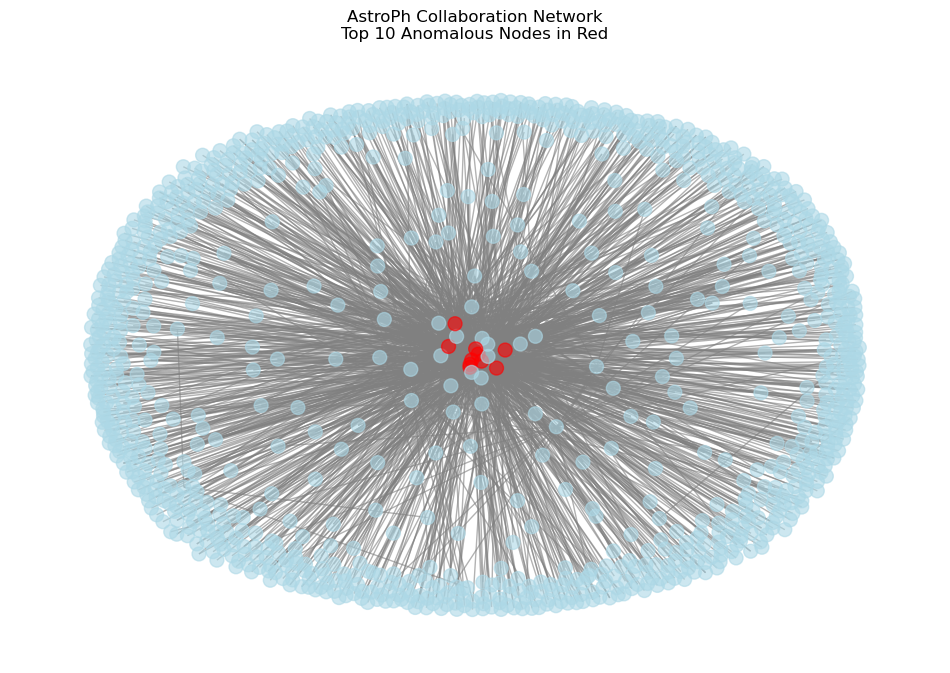

In [8]:
import matplotlib.pyplot as plt


def draw_graph_with_anomalies(G):
    nodes_sorted = sorted(G.nodes(), key=lambda x: G.nodes[x]['anomaly_score'], reverse=True)
    top_10_nodes = set(nodes_sorted[:10])
    
    color_map = ['red' if node in top_10_nodes else 'lightblue' for node in G.nodes()]
    
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos,
            node_color=color_map,
            node_size=100,
            with_labels=False,
            alpha=0.6,
            edge_color='gray',
            ax=ax)  
    
    plt.title("AstroPh Collaboration Network\nTop 10 Anomalous Nodes in Red")
    
    print("\nTop 10 most anomalous nodes:")
    for node in nodes_sorted[:10]:
        print(f"Node {node}: score = {G.nodes[node]['anomaly_score']:.4f}")
    
    
graph_path = 'ca-AstroPh.txt'
G = load_astro_ph_graph(graph_path, limit=1500)  
G = extract_egonet_features(G)

G = compute_anomaly_scores(G)

draw_graph_with_anomalies(G)

I tried adding interactivity to the graph without much success..


Top 10 most anomalous nodes (combined score):
Node 126916: score = 17.1716
Node 84424: score = 14.4458
Node 94138: score = 14.3735
Node 106274: score = 13.9708
Node 127393: score = 13.1785
Node 75607: score = 12.5068
Node 13353: score = 12.1552
Node 60471: score = 12.0442
Node 35690: score = 11.8747
Node 30625: score = 11.1328


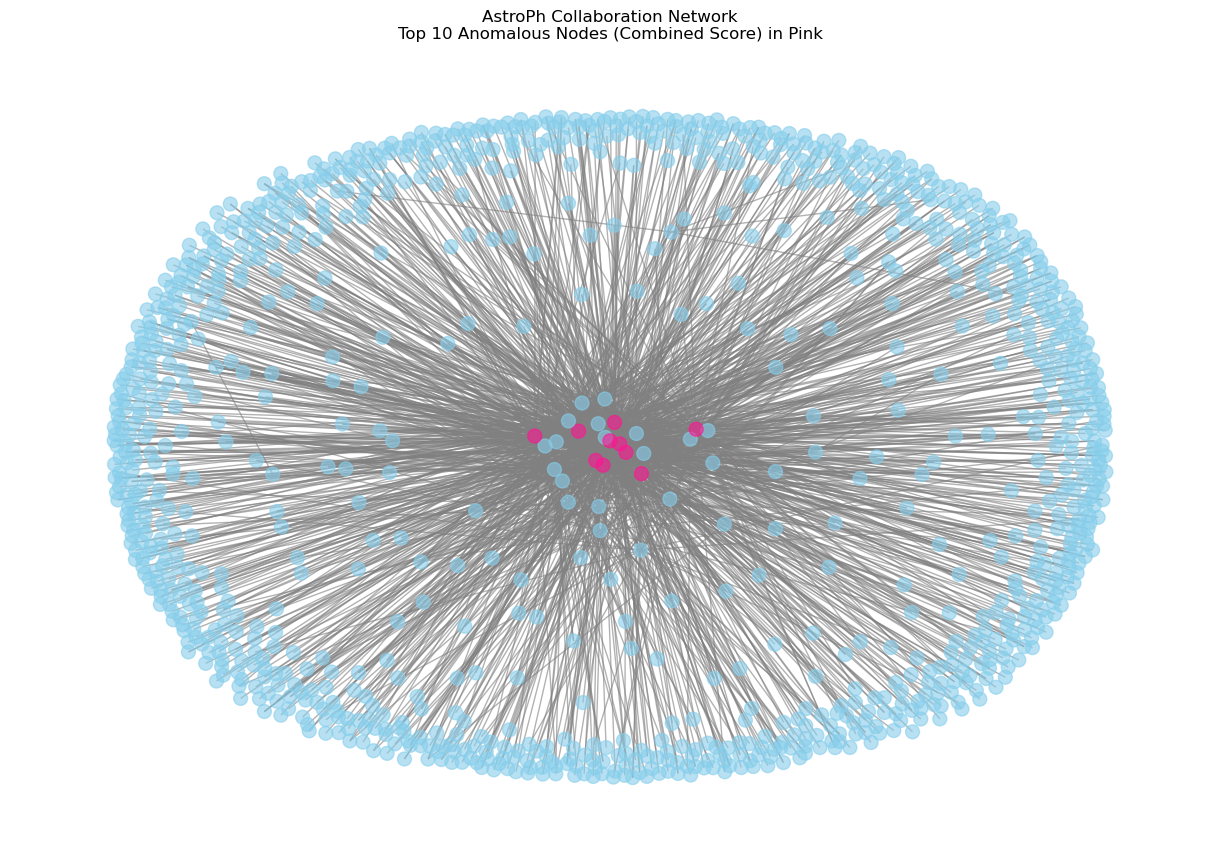

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

def compute_combined_anomaly_scores(G):
    nodes = list(G.nodes())
    E_values = np.array([G.nodes[node]['E'] for node in nodes])
    N_values = np.array([G.nodes[node]['N'] for node in nodes])
    
    G = compute_anomaly_scores(G)  
    original_scores = np.array([G.nodes[node]['anomaly_score'] for node in nodes])
    
    scaler = StandardScaler()
    normalized_original_scores = scaler.fit_transform(original_scores.reshape(-1, 1)).flatten()
    
    features = np.column_stack([E_values, N_values])
    lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
    lof_scores = -lof.fit_predict(features)
    
    normalized_lof_scores = scaler.fit_transform(lof_scores.reshape(-1, 1)).flatten()
    
    combined_scores = normalized_original_scores + normalized_lof_scores
    
    combined_scores_dict = dict(zip(nodes, combined_scores))
    nx.set_node_attributes(G, combined_scores_dict, 'combined_anomaly_score')
    
    return G

def draw_graph_with_combined_anomalies(G):
    nodes_sorted = sorted(G.nodes(), 
                        key=lambda x: G.nodes[x]['combined_anomaly_score'], 
                        reverse=True)
    top_10_nodes = set(nodes_sorted[:10])
    
    color_map = ['#FF1493' if node in top_10_nodes else '#87CEEB' for node in G.nodes()]
    
    plt.figure(figsize=(12, 8))
    
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos,
            node_color=color_map,
            node_size=100,
            with_labels=False,
            alpha=0.6,
            edge_color='gray')

    plt.title("AstroPh Collaboration Network\nTop 10 Anomalous Nodes (Combined Score) in Pink")
    
    print("\nTop 10 most anomalous nodes (combined score):")
    for node in nodes_sorted[:10]:
        print(f"Node {node}: score = {G.nodes[node]['combined_anomaly_score']:.4f}")
    
    plt.show()

graph_path = 'ca-AstroPh.txt'
G = load_astro_ph_graph(graph_path, limit=1500)  
G = extract_egonet_features(G)

G = compute_combined_anomaly_scores(G)

draw_graph_with_combined_anomalies(G)